In [ ]:
import os
import re
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import ptitprince as pt
from scipy.io import loadmat
from matplotlib import rcParams
import matplotlib.pyplot as plt

# if 'win' in sys.platform:
#     rcParams['font.size'] = 14
#     rcParams['text.usetex'] = True
#     rcParams['text.latex.preamble'] = r'\usepackage[charter,cal=cmcal]{mathdesign}'


def plot_raincloud(overlaps: np.ndarray):
    # plt.figure(figsize=(7, 6))
    plt.figure(figsize=(5, 4))
    data = {r'$|\varphi_{\!' + f'{i+1}' + r'}\rangle$': overlaps[:, i] for i in range(num_phi)}
    df = pd.DataFrame(data)
    pt.half_violinplot(data=df, scale='count', width=0.8, inner=None, linewidth=1.2, palette=colors)
    sns.stripplot(data=df, jitter=True, palette=colors, size=1.5)
    plt.ylabel('Overlaps', labelpad=10, fontsize=16)
    plt.yticks(np.linspace(0, 1, 11))
    plt.xlim(-0.8, 3.4)

    # plt.savefig(f'{path_img}.pdf', bbox_inches='tight')
    # plt.savefig(f'{path_img}.png', dpi=400, bbox_inches='tight')
    plt.show()


num, date, time = 0, 20250226, 130000
pattern = r'(VGON_nqd\d+_L\d+_(\d{8})_(\d{6})).mat'
path, path_img = './mats', './img/overlaps_raincloud'
colors = ['#74B816', '#339AF0', '#FD7E14', '#F03E3E']
for name in sorted(os.listdir(path), reverse=True):
    match = re.search(pattern, name)
    if match and date <= int(match.group(2)) and time <= int(match.group(3)):
        load = loadmat(f'{path}/{name}')
        energy = load['energy'].item()
        n_qudits = load['n_qudits'].item()
        energy_gap = energy - load['ground_state_energy'].item()
        if 'n_train' in load:
            info_str = load['n_train'].item()
        elif 'n_iter' in load:
            info_str = load['n_iter'].item()
        if 'fidelity_max' in load:
            fidelity_max = load['fidelity_max'].item()
            fidelity_mean = load['fidelity_mean'].item()
            info_str = f'Fidelity: {fidelity_max:.8f}, {fidelity_mean:.8f}, {info_str}'
        if 'cos_sim_max' in load:
            cos_sim_max = load['cos_sim_max'].item()
            cos_sim_mean = load['cos_sim_mean'].item()
            info_str = f'Cos_Sim: {cos_sim_max:.8f}, {cos_sim_mean:.8f}, {info_str}'
        if 'overlaps' in load:
            num += 1
            overlaps = load['overlaps']
            num_phi = overlaps.shape[1]
            if 'count' in load:
                count = load['count'].item()
                info_str += f', {count}'
            else:
                info_str += f', {overlaps.shape[0]}'
            print(f'{num:2d}, {name}, Energy: {energy:.8f}, {energy_gap:.4e}, {info_str}')
            plot_raincloud(overlaps)
        else:
            num += 1
            print(f'{num:2d}, {name}, Energy: {energy:.8f}, {energy_gap:.4e}, {info_str}, No overlaps')

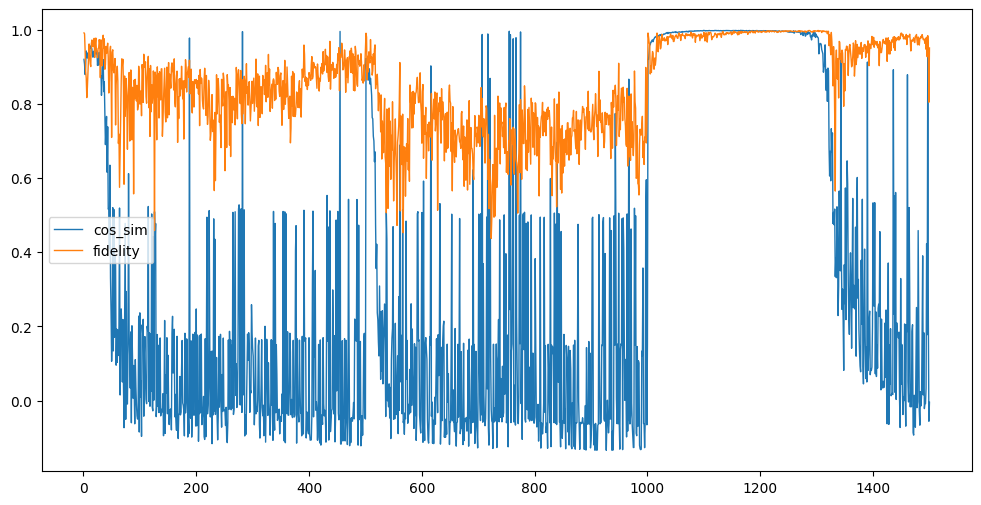

In [134]:
energy, fidelity, cos_sim = [], [], []
with open('./logs/VGON_nqd4_L3_phase_202502.log') as f:
    lines, count = f.readlines(), 0
    for line in lines:
        energy_pattern = r'Energy: (-*\d\.\d+)'
        fidelity_pattern = r'Fidelity: (\d\.\d+), (\d\.\d+), (\d\.\d+)'
        cos_sim_pattern = r'Cos_Sim: (\d\.\d+), .+\*(-*\d\.\d+), (-*\d\.\d+)'
        energy_match = re.search(energy_pattern, line)
        cos_sim_match = re.search(cos_sim_pattern, line)
        fidelity_match = re.search(fidelity_pattern, line)
        if energy_match and cos_sim_match and fidelity_match:
            energy.append(float(energy_match.group(1)))
            cos_sim.append(list(map(float, cos_sim_match.group(1, 2, 3))))
            fidelity.append(list(map(float, fidelity_match.group(1, 2, 3))))
energy, cos_sim, fidelity = np.array(energy), np.array(cos_sim), np.array(fidelity)
x = np.arange(len(energy)) + 1
plt.figure(figsize=(12, 6))
# plt.plot(x, energy, label='energy')
plt.plot(x, cos_sim[:, 1], linewidth=1, label='cos_sim')
plt.plot(x, fidelity[:, 1], linewidth=1, label='fidelity')
plt.legend()
plt.show()

In [ ]:
import os
import re
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt


def plot_iteration(task, phase: str, energy_iter: np.ndarray):
    x = 1 + np.arange(len(energy_iter))
    axs[i].plot(x, energy_iter - ground_state_energy, label=f'{task}_L{n_layers}')
    axs[i].axhline(1e-2, color='r', linestyle='--')
    axs[i].axhline(1e-1, color='g', linestyle='--')
    axs[i].set_title(phase, fontsize=12)
    axs[i].set_xlabel('Iteration', fontsize=12)
    axs[i].set_ylabel('Energy', fontsize=12)
    axs[i].legend(loc='upper right')
    axs[i].set_yscale('log')


path, path_img = './mats', './img'
coeffs = np.array([-0.74, 0.49])
_, axs = plt.subplots(1, 2, figsize=(12, 5))
for name in sorted(os.listdir(path), reverse=False):
    match = re.search(r'(VGON|VQE)+_nqd7_L\d+_(\d{8})_\d{6}.mat', name)
    if match:
        task = match.group(1)
        load = loadmat(f'{path}/{name}')
        phase = load['phase'].item()
        n_iter = load['n_iter'].item()
        energy = load['energy'].item()
        n_train = load['n_train'].item()
        n_layers = load['n_layers'].item()
        n_qudits = load['n_qudits'].item()
        batch_size = load['batch_size'].item()
        energy_iter = load['energy_iter'].squeeze()
        ground_state_energy = load['ground_state_energy'].item()
        energy_gap = energy - ground_state_energy
        if energy_iter.ndim > 1:
            energy_iter = energy_iter.mean(axis=1)
        if '-0.74π' == phase:
            i = 0
        elif '0.49π' == phase:
            i = 1
        else:
            i = None
        if i is not None and n_iter >= 500 and n_layers >= 2 and (task == 'VQE' or task == 'VGON' and int(match.group(2)) >= 20250117):
            # print(f'{name}, {phase}, Energy: {energy:.8f}, {energy_gap:.4e}, {n_train}')
            plot_iteration(task, phase, energy_iter[0:])

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import ptitprince as pt
from scipy.io import loadmat
import matplotlib.pyplot as plt


def plot_raincloud(overlaps: np.ndarray):
    plt.figure(figsize=(7, 6))
    degeneracy = overlaps.shape[1]
    colors = ['#74B816', '#339AF0', '#FD7E14', '#F03E3E']
    data = {r'$|\varphi_{\!' + f'{i+1}' + r'}\rangle$': overlaps[:, i] for i in range(degeneracy)}
    df = pd.DataFrame(data)
    pt.half_violinplot(data=df, scale='count', width=1, inner=None, linewidth=1.2, palette=colors, alpha=0.8)
    sns.stripplot(data=df, jitter=True, palette=colors, size=1)
    plt.ylabel('Overlaps', labelpad=10, fontsize=16)
    # plt.yticks(np.linspace(0, 1, 11))
    plt.xlim(-0.8, degeneracy - 0.6)
    plt.title(f'VGON L{n_layers} {phase} {n_train}')
    plt.show()


pattern = r'(VGON_nqd7_L\d+_(\d{8})_\d{6}).mat'
for name in sorted(os.listdir('./mats'), reverse=True):
    match = re.search(pattern, name)
    if match and int(match.group(2)) >= 20250117:
        path = f'./mats/{match.group(1)}'
        load = loadmat(f'{path}.mat')
        if 'overlaps' in load:
            overlaps = load['overlaps']
            phase = load['phase'].item()
            n_train = load['n_train'].item()
            n_layers = load['n_layers'].item()
            plot_raincloud(overlaps)

In [ ]:
def warmup_lr(epoch, warmup_epochs):
    if (div := epoch / warmup_epochs) < 1:
        return 10 * div + 1
    else:
        return 10 * np.exp(2 * (1 - div)) + 1


epochs = 500
warmup_epochs = 100
learning_rate = 1e-4
x = np.arange(epochs)
lr_list = [warmup_lr(i, warmup_epochs) * learning_rate for i in range(epochs)]
plt.plot(x, lr_list)
plt.axvline(warmup_epochs, color='r', linestyle='--')
plt.axhline(learning_rate, color='r', linestyle='--')
# plt.yscale('log')

In [ ]:
import os
import re
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt


def plot_iteration(task, phase: str, weight_decay, learning_rate, energy_iter: np.ndarray, fidelity_iter: np.ndarray):
    # _, axs = plt.subplots(1, 2, figsize=(12, 5))
    x0 = 1 + np.arange(len(energy_iter))
    x1 = 1 + np.arange(len(fidelity_iter))
    energy_max = np.ceil(energy_iter.max())
    energy_min = np.floor(energy_iter.min())

    axs[i][0].plot(x0, energy_iter, label=f'{task}_L{n_layers}_{phase}')
    axs[i][0].axhline(ground_state_energy, color='r', linestyle='--')
    axs[i][0].axhline(ground_state_energy + 0.1, color='g', linestyle='--')
    axs[i][0].set_title(phase, fontsize=12)
    # axs[i][0].set_xlabel('Iteration', fontsize=12)
    axs[i][0].set_ylabel('Energy', fontsize=12)
    # axs[i][0].set_xticks(np.linspace(0, max(x0), 5))
    # axs[i][0].set_yticks(np.linspace(energy_min, energy_max, 11))
    # axs[i][0].legend(loc='upper right')

    axs[i][1].plot(x1, fidelity_iter, label=f'{task}_L{n_layers}_{phase}_wd{weight_decay:.0e}_lr{learning_rate:.0e}')
    axs[i][1].set_title(phase, fontsize=12)
    # axs[i][1].set_xlabel('Iteration', fontsize=12)
    axs[i][1].set_ylabel('Fidelity', fontsize=12)
    if fidelity_iter.max() > 0.9:
        axs[i][1].axhline(1, color='r', linestyle='--')
        axs[i][1].axhline(0.95, color='g', linestyle='--')
        axs[i][1].set_ylim(-0.05, 1.05)
        axs[i][1].set_yticks(np.linspace(0, 1, 11))
    # axs[i][1].set_xticks(np.linspace(0, max(x1), 5))
    axs[i][1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # axs[i][1].legend(loc='lower right')
    # axs[i][1].legend()


date = '202501'
path, path_img = './mats', './img'
coeffs = np.array([-0.74, 0.49])
# coeffs = np.linspace(-0.75, 0.50, 26)
# coeffs[0] += 0.01
# coeffs[-1] -= 0.01
num = coeffs.shape[0]
_, axs = plt.subplots(num, 2, figsize=(12, 5 * num))
for name in sorted(os.listdir(path), reverse=True):
    match = re.search(r'(VGON|VQE)+_nqd\d+(_L\d+)+_\d{8}_\d{6}.mat', name)
    if match:
        task = match.group(1)
        load = loadmat(f'{path}/{name}')
        n_iter = load['n_iter'].item()
        energy = load['energy'].item()
        n_train = load['n_train'].item()
        n_qudits = load['n_qudits'].item()
        batch_size = load['batch_size'].item()
        weight_decay = load['weight_decay'].item()
        learning_rate = load['learning_rate'].item()

        if 'phase' in load and 'n_layers' in load and 'energy_iter' in load and 'fidelity_iter' in load:
            phase = load['phase'].item()
            n_layers = load['n_layers'].item()
            fidelity = load['fidelity'].squeeze()
            energy_iter = load['energy_iter'].squeeze()
            fidelity_iter = load['fidelity_iter'].squeeze()
            ground_state_energy = load['ground_state_energy'].item()
            energy_gap = energy - ground_state_energy

            if energy_iter.ndim > 1:
                energy_iter = energy_iter.mean(axis=1)
            if fidelity_iter.ndim > 2:
                fidelity_iter = fidelity_iter.mean(axis=1).sum(axis=1)
            elif fidelity_iter.ndim > 1:
                fidelity_iter = fidelity_iter.sum(axis=1)

            for i, j in enumerate(coeffs):
                if '-0.74π' == phase:
                    i = 0
                    break
                elif '0.49π' == phase:
                    i = num - 1
                    break
                elif f'{j:.2f}π' == phase:
                    # print(name, i, f'{j:.2f}π', phase)
                    break
            else:
                i = None

            if i is not None and n_qudits == 7 and n_iter >= 500 and n_layers <= 2 and energy_gap < 0.2:
                print(f'{name}, {i}, {phase}, Fidelity: {fidelity.sum():.8f}, wd: {weight_decay:.0e}, lr: {learning_rate:.0e}, {n_train}')
                # print(f'Ground State Energy: {ground_state_energy:.8f}, Energy: {energy:.8f}, Gap: {energy-ground_state_energy:.4e}')
                plot_iteration(task, phase, weight_decay, learning_rate, energy_iter[0:], fidelity_iter[0:])

In [ ]:
import re
import sys
import numpy as np
from scipy.io import loadmat
from matplotlib import rcParams
import matplotlib.pyplot as plt

if 'win' in sys.platform:
    rcParams['font.size'] = 12
    rcParams['text.usetex'] = True
    rcParams['text.latex.preamble'] = r'\usepackage[charter,cal=cmcal]{mathdesign}'


def slice_data(data: list | np.ndarray, start: int = 0, step: int = 5):
    return np.append(data[:start], data[start::step])


def plot_iteration(energy_iter: np.ndarray, fidelity_iter: np.ndarray):
    x0 = 1 + np.arange(len(energy_iter))
    x1 = 1 + np.arange(len(fidelity_iter))
    if energy_iter[0] > 3:
        energy_iter[0] -= 4
    if energy_iter[1] > 3:
        energy_iter[1] -= 4
    energy_max = np.ceil(energy_iter.max())
    energy_min = np.floor(energy_iter.min())
    color = '#E08131' if task == 'VQE' else '#4B98D8'

    axs[0].plot(x0, energy_iter, label=f'{task}', color=color)
    axs[0].scatter(slice_data(x0), slice_data(energy_iter), s=8, color=color)
    if task == 'VGON':
        axs[0].axhline(ground_state_energy, color='#F03E3E', linewidth=1, linestyle='--', label='Ground energy')
    else:
        axs[0].axhline(ground_state_energy, color='#F03E3E', linewidth=1, linestyle='--')
    axs[0].set_xlabel('Iteration', fontsize=14)
    axs[0].set_ylabel('Energy', labelpad=0, fontsize=14)
    axs[0].set_xticks(np.linspace(0, max(x0), 5))
    axs[0].set_yticks(np.linspace(energy_min, energy_max, 11))
    axs[0].legend(loc='right', fontsize=12)

    axs[1].plot(x1, fidelity_iter, label=f'{task}', color=color)
    axs[1].scatter(slice_data(x1), slice_data(fidelity_iter), s=8, color=color)
    axs[1].set_xlabel('Iteration', fontsize=14)
    axs[1].set_ylabel('Fidelity', labelpad=6, fontsize=14)
    if fidelity_iter.max() > 0.9 and task == 'VGON':
        axs[1].axhline(1, color='#DA5454', linewidth=1, linestyle='--', label=r'$\mathcal{F}=1$')
        # axs[1].axhline(0.95, color='#558b2f', linewidth=1, linestyle='--', label=r'$\mathcal{F}=0.95$')
        axs[1].set_ylim(-0.05, 1.05)
        axs[1].set_yticks(np.linspace(0, 1, 11))
    axs[1].legend(loc='right', fontsize=12)


path, path_img = './mats', './img/plot_iteration'
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
name_list = ['VQE_nqd7_L2_20241222_231616', 'VGON_nqd7_L2_20241222_102016']
for name in name_list:
    match = re.search(r'(VGON|VQE)+_nqd\d+(_L\d+)*_\d{8}_\d{6}', name)
    task = match.group(1)
    phase = r'$\arctan\,(1/3)$'
    load = loadmat(f'{path}/{name}.mat')
    n_layers = load['n_layers'].item()
    fidelity = load['fidelity'].squeeze()
    energy_iter = load['energy_iter'].squeeze()
    fidelity_iter = load['fidelity_iter'].squeeze()
    ground_state_energy = load['ground_state_energy'].item()

    if energy_iter.ndim > 1:
        energy_iter = energy_iter.mean(axis=1)
    if fidelity_iter.ndim > 2:
        fidelity_iter = fidelity_iter.mean(axis=1).sum(axis=1)
    elif fidelity_iter.ndim > 1:
        fidelity_iter = fidelity_iter.sum(axis=1)

    plot_iteration(energy_iter[:300], fidelity_iter[:300])
plt.subplots_adjust(wspace=0.23)
# plt.savefig(f'{path_img}.p/g', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
import re
import sys
import numpy as np
from scipy.io import loadmat
from matplotlib import rcParams
import matplotlib.pyplot as plt

if 'win' in sys.platform:
    rcParams['font.size'] = 14
    rcParams['text.usetex'] = True
    rcParams['text.latex.preamble'] = r'\usepackage[charter,cal=cmcal]{mathdesign}'


def slice_data(data: list | np.ndarray, start: int = 0, step: int = 5):
    return np.append(data[:start], data[start::step])


def plot_iteration(energy_iter: np.ndarray, fidelity_iter: np.ndarray):
    x0 = 1 + np.arange(len(energy_iter))
    x1 = 1 + np.arange(len(fidelity_iter))
    energy_max = np.ceil(energy_iter.max())
    energy_min = np.floor(energy_iter.min())
    color = '#E08131' if task == 'VQE' else '#4B98D8'

    axs0.plot(x0, energy_iter, label=f'{task}', color=color)
    axs0.scatter(slice_data(x0), slice_data(energy_iter), s=8, color=color)
    axs0.axhline(ground_state_energy, color='#F03E3E', linewidth=1, linestyle='--')
    axs0.set_xlabel('Iteration', fontsize=14)
    axs0.set_ylabel('Energy', labelpad=0, fontsize=14)
    axs0.set_xticks(np.linspace(0, max(x0), 5))
    axs0.set_yticks(np.linspace(energy_min, energy_max, 11))
    # axs0.legend(loc='right', fontsize=12)

    axs1 = axs0.twinx()
    axs1.plot(x1, fidelity_iter, color=color)
    axs1.scatter(slice_data(x1), slice_data(fidelity_iter), s=8, color=color)
    axs1.set_xlabel('Iteration', fontsize=14)
    axs1.set_ylabel('Fidelity', labelpad=6, fontsize=14)
    if fidelity_iter.max() > 0.9:
        axs1.axhline(1, color='#DA5454', linewidth=1, linestyle='--')
        axs1.axhline(0.95, color='#558b2f', linewidth=1, linestyle='--')
        axs1.set_ylim(-0.05, 1.05)
        axs1.set_yticks(np.linspace(0, 1, 11))


path, path_img = './mats', './img'
fig, axs0 = plt.subplots(figsize=(7, 6))
name_list = ['VQE_nqd7_L2_20241222_231616', 'VGON_nqd7_L2_20241222_102016']
for name in name_list:
    match = re.search(r'(VGON|VQE)+_nqd\d+(_L\d+)*_\d{8}_\d{6}', name)
    task = match.group(1)
    phase = r'$\arctan\,(1/3)$'
    load = loadmat(f'{path}/{name}.mat')
    n_layers = load['n_layers'].item()
    fidelity = load['fidelity'].squeeze()
    energy_iter = load['energy_iter'].squeeze()
    fidelity_iter = load['fidelity_iter'].squeeze()
    ground_state_energy = load['ground_state_energy'].item()

    if energy_iter.ndim > 1:
        energy_iter = energy_iter.mean(axis=1)
    if fidelity_iter.ndim > 2:
        fidelity_iter = fidelity_iter.mean(axis=1).sum(axis=1)
    elif fidelity_iter.ndim > 1:
        fidelity_iter = fidelity_iter.sum(axis=1)

    plot_iteration(energy_iter[:300], fidelity_iter[:300])

fig.legend(loc='right', bbox_to_anchor=(0.85, 0.5), fontsize=12)
# plt.savefig(f'{path_img}.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import ptitprince as pt
from utils import fidelity
from scipy.io import loadmat
import matplotlib.pyplot as plt
from qudit_mapping import symmetric_decoding


def plot_stack(overlaps_sorted):
    plt.figure(figsize=(7, 6))
    colors = ['#C0EB75', '#A5D8FF', '#FFC078', '#FF8787']
    psi = [r'$|\psi_{\!' + f'{i+1}' + r'}\rangle$' for i in range(num_psi)]
    phi = [r'$|\varphi_{\!' + f'{i+1}' + r'}\rangle$' for i in range(degeneracy)]
    for ind in range(degeneracy)[::-1]:
        bottom = overlaps_sorted[:, ind + 1:].sum(axis=1)
        plt.bar(psi, overlaps_sorted[:, ind], bottom=bottom, color=colors[ind], label=phi[ind])
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=reversed(handles), labels=reversed(labels), loc='lower right')
    plt.ylabel('Overlaps', labelpad=10, fontsize=16)
    plt.yticks(np.linspace(0, 1, 11))
    plt.show()


def plot_raincloud(overlaps: np.ndarray):
    plt.figure(figsize=(7, 6))
    colors = ['#74B816', '#339AF0', '#FD7E14', '#F03E3E']
    data = {r'$|\varphi_{\!' + f'{i+1}' + r'}\rangle$': overlaps[:, i] for i in range(degeneracy)}
    df = pd.DataFrame(data)
    pt.half_violinplot(data=df, scale='count', width=1, inner=None, linewidth=1.2, palette=colors, alpha=0.8)
    sns.stripplot(data=df, jitter=True, palette=colors, size=3)
    plt.ylabel('Overlaps', labelpad=10, fontsize=16)
    plt.yticks(np.linspace(0, 1, 11))
    plt.xlim(-0.8, degeneracy - 0.6)
    plt.show()


num_psi, n_qudits = 0, 7
phase, date = '0.49π', '202412'
degeneracy = 4 if phase == 'arctan(1/3)' else 3
overlaps = np.empty((0, degeneracy))
decoded_states = np.empty((0, 3**n_qudits))
ED_states = loadmat('./mats/ED_degeneracy.mat')[f'nqd{n_qudits}'][0, 1].T
ED_states[np.abs(ED_states) < 1e-15] = 0

for name in sorted(os.listdir('./mats')):
    match = re.search(r'VQE_nqd\d+(_L\d+)*_\d{8}_\d{6}.mat', name)
    if match and date in name:
        load = loadmat(f'./mats/{name}')
        if phase == load['phase'].item():
            energy = load['energy'].item()
            state = load['states_res'].squeeze()
            ground_states = load['ground_states']
            decoded_state = symmetric_decoding(state, n_qudits)
            ground_state_energy = load['ground_state_energy'].item()
            decoded_states = np.vstack((decoded_states, decoded_state))
            overlap = np.array([fidelity(decoded_state, ground_state) for ground_state in ground_states])
            if overlap.sum() > 0.0:
                num_psi += 1
                overlaps = np.vstack((overlaps, overlap))
                print(f'{name[:-4]} {phase} {energy-ground_state_energy:.4e} {overlap.sum():.4f} {overlap}')
overlaps_sorted = overlaps[np.argsort(overlaps[:, degeneracy - 1])]
plot_stack(overlaps_sorted)
plot_raincloud(overlaps_sorted)

- 0.32π
  - N = 6: 2.08244143
  - N = 8: 3.13198413
- -0.71π: 
  - N = 6: -8.50190201
  - N = 8: -11.79969874
- -0.30π: 
  - N = 6: -16.15097766
  - N = 8: -22.05015431
- -0.16π: 
  - N = 6: -13.30302704
  - N = 8: -18.16127406
- arctan(1/3): 
  - N = 6: -3.16227766
  - N = 8: -4.42718872

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import ptitprince as pt
from scipy.io import loadmat
import matplotlib.pyplot as plt


def plot_raincloud(overlaps: np.ndarray, name: str, num: int):
    data = {r'$|\varphi_{\!' + f'{i+1}' + r'}\rangle$': overlaps[:, i] for i in range(num_phi)}
    i, j = num // 6, num % 6
    df = pd.DataFrame(data)
    pt.half_violinplot(data=df, scale='count', width=0.6, inner=None, linewidth=1.2, palette=colors, ax=axs[i][j])
    sns.stripplot(data=df, jitter=True, palette=colors, size=1, ax=axs[i][j])
    axs[i][j].set_yticks(np.linspace(0, 1, 11))
    axs[i][j].set_xlabel(name[10:25])
    axs[i][j].set_xlim(-0.8, 3.4)
    axs[i][j].set_xticks([])


num, date = 0, '20241210'
fig, axs = plt.subplots(5, 6, figsize=(18, 15))
path, path_img = './mats', './img/overlaps_raincloud'
colors = ['#74B816', '#339AF0', '#FD7E14', '#F03E3E']
for name in sorted(os.listdir(path), reverse=True):
    match = re.search(r'(VGON_nqd\d+_\d{8}_\d{6}).mat', name)
    if match and date in name:
        load = loadmat(f'{path}/{name}')
        energy = load['energy'].item()
        n_qudits = load['n_qudits'].item()
        if 'n_train' in load:
            info_str = str(load['n_train'].item())
        elif 'n_iter' in load:
            info_str = str(load['n_iter'].item())
        if 'fidelity_max' in load:
            fidelity_max = load['fidelity_max'].item()
        if 'overlaps' in load:
            if energy < -3.99 and fidelity_max < 0.98:
                overlaps = load['overlaps']
                num_phi = overlaps.shape[1]
                if 'count' in load:
                    info_str += ', ' + load['count'].item()
                else:
                    info_str += ', ' + str(overlaps.shape[0])
                plot_raincloud(overlaps, name, num)
                num += 1
        else:
            print(f'{name}, Energy: {energy:.8f}, Fidelity: {fidelity_max:.8f}, {info_str}, No overlaps')

In [ ]:
import sys
import numpy as np
from scipy.io import loadmat
from matplotlib import rcParams
import matplotlib.pyplot as plt

if 'win' in sys.platform:
    rcParams['font.size'] = 14
    rcParams['text.usetex'] = True
    rcParams['text.latex.preamble'] = r'\usepackage[charter,cal=cmcal]{mathdesign}'


def plot_stack(overlaps_sorted):
    plt.figure(figsize=(7, 6))
    psi = [r'$|\psi_{\!' + f'{i+1}' + r'}\rangle$' for i in range(num_psi)]
    phi = [r'$|\varphi_{\!' + f'{i+1}' + r'}\rangle$' for i in range(num_phi)]
    for ind in range(num_phi)[::-1]:
        bottom = overlaps_sorted[:, ind + 1:].sum(axis=1)
        plt.bar(psi, overlaps_sorted[:, ind], bottom=bottom, color=colors[ind], label=phi[ind])
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=reversed(handles), labels=reversed(labels), loc='lower right')
    plt.ylabel('Overlaps', labelpad=10, fontsize=16)
    plt.yticks(np.linspace(0, 1, 11))

    # plt.savefig(f'{path_img}.pdf', bbox_inches='tight')
    # plt.savefig(f'{path_img}.png', dpi=400, bbox_inches='tight')
    plt.show()


def running(i: int, j: float, k: float, tol: float, overlaps: np.ndarray):
    np.random.seed(i)
    num_phi = overlaps.shape[1]
    overlaps_rand_perm = np.random.permutation(overlaps)
    overlaps_selected = np.empty([0, num_phi])
    for x in overlaps_rand_perm:
        if overlaps_selected.any():
            if overlaps_selected.ndim > 1:
                xmin = np.abs(x - overlaps_selected)[:, 1:4].min()
            else:
                xmin = np.abs(x - overlaps_selected).min()
            if np.min(x) > j and xmin > tol:
                overlaps_selected = np.vstack((overlaps_selected, x))
        else:
            if np.min(x) > k:
                overlaps_selected = x
    if overlaps_selected.shape[0] >= 10:
        overlaps_selected = overlaps_selected[0:10]
        overlaps_sorted = overlaps_selected[np.argsort(overlaps_selected[:, 3])]
        plot_stack(overlaps_sorted)
        # print(overlaps_sorted)


date = '20241210_063152'
path, path_img = './mats', './img/overlaps_stack'
colors = ['#C0EB75', '#A5D8FF', '#FFC078', '#FF8787']
load = loadmat(f'{path}/VGON_nqd7_{date}.mat')
overlaps = load['overlaps']
num_psi, num_phi = 10, overlaps.shape[1]

i, j, k, tol = 5962, 0.08, 0.08, 0.03
running(i, j, k, tol, overlaps)

- 20241210_063152
  - 401, 0.07, 0.10, 0.03, 1:4
  - 523, 0.07, 0.10, 0.03, 1:4
  - 964, 0.07, 0.08, 0.03, 1:4
  - 5962, 0.08, 0.08, 0.03, 1:4
  - 9315, 0.08, 0.10, 0.04, 2:4
  - 624, 0.07, 0.07, 0.02
  - 770, 0.07, 0.07, 0.02
  - 98, 0.05, 0.10, 0.025
  - 300, 0.05, 0.08, 0.025
  - 352, 0.05, 0.10, 0.025
  - 781, 0.05, 0.05, 0.025

- 20241127_033736
  - 743, 0.05, 0.05, 0.02
  - 884, 0.05, 0.05, 0.02
  - 977, 0.05, 0.1, 0.02

In [ ]:
import numpy as np
import multiprocessing
from scipy.io import loadmat


def running(i: int, tol: float, overlaps: np.ndarray):
    np.random.seed(i)
    num_phi = overlaps.shape[1]
    overlaps_rand_perm = np.random.permutation(overlaps)
    for j in [0.1, 0.09, 0.08, 0.07, 0.06, 0.05][:3]:
        for k in [0.1, 0.09, 0.08, 0.07, 0.06, 0.05][:3]:
            overlaps_selected = np.empty([0, num_phi])
            for x in overlaps_rand_perm:
                if overlaps_selected.any():
                    if overlaps_selected.ndim > 1:
                        xmin = np.abs(x - overlaps_selected)[:, 1:4].min()
                    else:
                        xmin = np.abs(x - overlaps_selected).min()
                    if np.min(x) > j and xmin > tol:
                        overlaps_selected = np.vstack((overlaps_selected, x))
                else:
                    if np.min(x) > k:
                        overlaps_selected = x
            if overlaps_selected.shape[0] >= 10:
                print(f'{i}, {j:.2f}, {k:.2f}, {tol:.2f}')
                break


date = '20241210_063152'
load = loadmat(f'./mats/VGON_nqd7_{date}.mat')
overlaps = load['overlaps']

tol = 0.03
pool = multiprocessing.Pool(32)
for i in range(10000):
    pool.apply_async(running, (i, tol, overlaps))
pool.close()
pool.join()

```python
seaborn version: 0.11.0
ptitprince version: 0.2.7

.../site-packages/seaborn/axisgrid.py
677  plot_args = [v for k, v in plot_data.items()]  # zyz: replace .iteritems() with .items()

.../site-packages/seaborn/categorical.py
81  iter_data = plot_data.items()  # zyz: replace .iteritems() with .items()

.../site-packages/seaborn/cm.py
1  import matplotlib as mpl
...
1583  # mpl_cm.register_cmap(_name, _cmap)
1584  # mpl_cm.register_cmap(_name + "_r", _cmap_r)
1585
1586  # zyz: replace matplotlib.cm.register with matplotlib.colormaps.register
1587  mpl.colormaps.register(name=_name, cmap=_cmap)
1588  mpl.colormaps.register(name=_name + "_r", cmap=_cmap_r)
```